In [28]:
import sys

sys.path.insert(0, '..')

In [29]:
from __future__ import annotations
import os
import math
import argparse
from dataclasses import dataclass
from typing import List, Tuple, Dict

import numpy as np
from scipy import signal
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, TimeMasking, FrequencyMasking

In [30]:
sample_rate = 16000

# 512 important here for speech processing, ~23ms for our data from Libriparty
windowed_signal_length = 512
num_mel_bands = 40

ys, _ = librosa.load(path='voice.wav', sr=sample_rate)

fft_frame shape: (257, 1323)
mfsc shape: (40, 1323)


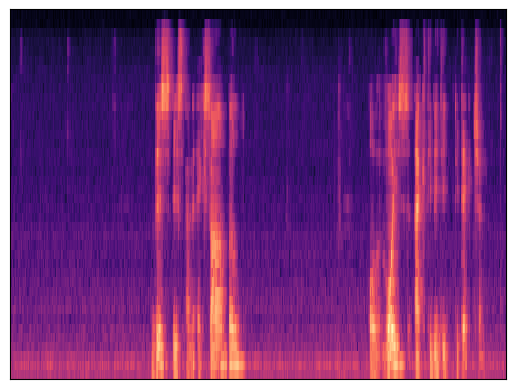

In [31]:
def compute_mfsc(ys, windowed_signal_length, sample_rate):
    fft_frames = librosa.stft(y=ys, n_fft=windowed_signal_length)
    print(f'fft_frame shape: {fft_frames.shape}')
    power_spectrum = np.abs(fft_frames) ** 2

    mel_filterbank = librosa.filters.mel(sr=sample_rate, n_fft=windowed_signal_length, n_mels=num_mel_bands)
    mel_energies = np.dot(mel_filterbank, power_spectrum)
    mfsc = np.log(mel_energies + 1e-10)
    return mfsc

mfsc = compute_mfsc(ys, windowed_signal_length, sample_rate)
print(f'mfsc shape: {mfsc.shape}')

librosa.display.specshow(mfsc)

In [32]:
model = nn.Sequential()

# convolutional layer 1
model.add_module(name='conv1', module=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1))
model.add_module(name='relu1', module=nn.ReLU())
model.add_module(name='pool1', module=nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', module=nn.Dropout(p=.5))

model.add_module(name='conv2', module=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module(name='relu2', module=nn.ReLU())
model.add_module(name='pool2', module=nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', module=nn.Dropout(p=.5))

model.add_module(name='conv3', module=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', module=nn.ReLU())        
model.add_module('pool3', module=nn.MaxPool2d(kernel_size=2))   

model.add_module(name='conv4', module=nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module(name='relu4', module=nn.ReLU())

In [33]:
x = torch.ones(4, 1, 40, 40)
model(x).shape
print(f'Model output dimensions before flattening: {model(x).shape}')

model.add_module(name='pool4', module=nn.AvgPool2d(kernel_size=5))
model.add_module(name='flatten', module=nn.Flatten())

print(f'Model after pooling and flattening: {model(x).shape}')

model.add_module(name='fc', module=nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=nn.Sigmoid())

print(f'Model shape after fully connected layer and eventual output: {model(x).shape}')
print(f'Model architecture:\n {model}')

Model output dimensions before flattening: torch.Size([4, 256, 5, 5])
Model after pooling and flattening: torch.Size([4, 256])
Model shape after fully connected layer and eventual output: torch.Size([4, 1])
Model architecture:
 Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size